In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [3]:
data = pd.read_csv('final-data.csv')

In [4]:
data['Week Endings'] = pd.to_datetime(data['Week Endings'], errors = 'raise')
data = data.sort_values(by='Week Endings', ascending=True)

In [5]:
# Truncating data after the release of the lion king movie
lk_release = datetime.date(2019, 7, 19)
boolean_mask = data['Week Endings'].dt.date < lk_release

In [6]:
# Data after the series has been truncated
print(data[boolean_mask].tail(5).to_string())
print(data[boolean_mask].shape)

    Week Endings  Avg Ticket Price ($)  Top Ticket Price ($)  Seats Sold  Seats in Theatre   % Cap
141   2019-06-16                171.79                 225.0       13565              1696   99.98
140   2019-06-23                178.53                 225.0       13569              1696  100.01
139   2019-06-30                179.18                 225.0       13550              1696   99.87
138   2019-07-07                190.91                 225.0       13519              1696   99.64
137   2019-07-14                187.67                 225.0       12759              1696   94.04
(1129, 6)


In [7]:
data = data[boolean_mask]

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1129 entries, 1265 to 137
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Week Endings          1129 non-null   datetime64[ns]
 1   Avg Ticket Price ($)  1129 non-null   float64       
 2   Top Ticket Price ($)  1129 non-null   float64       
 3   Seats Sold            1129 non-null   int64         
 4   Seats in Theatre      1129 non-null   int64         
 5   % Cap                 1129 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 61.7 KB


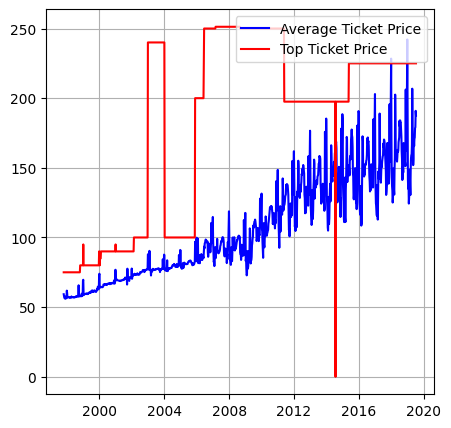

In [9]:
# Some basic plotting to check data and 
# data scale to determine whether data needs to be normalised or not
# before being used with the sequence model for prediction
# year = np.array(range(data.shape[0])) + 757
time = data['Week Endings']
plt.figure(figsize=(5, 5))
plt.grid(True)
plt.plot(time, data['Avg Ticket Price ($)'], color='b', label="Average Ticket Price")
plt.plot(time, data['Top Ticket Price ($)'], color='r', label="Top Ticket Price")
plt.legend(loc=1)
plt.show()

In [10]:
series = data['Avg Ticket Price ($)']
split_time = int(len(series) * 0.85)

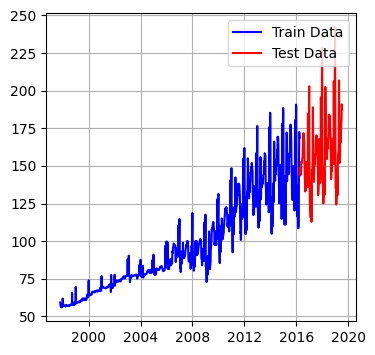

In [11]:
x_train = series[:split_time]
time_train = time[:split_time]
x_valid = series[split_time:]
time_valid = time[split_time:]

plt.figure(figsize=(4, 4))
plt.grid(True)
plt.plot(time_train, x_train, color='b', label="Train Data")
plt.plot(time_valid, x_valid, color='r', label="Test Data")
plt.legend(loc=1)
plt.show()

# Utilities:

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [30]:
# Defining parameters
window_size = 10
batch_size = 4
shuffle_buffer = 1000

In [31]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer)

In [32]:
# Checking the windowed training set:
list(train_set.take(2).as_numpy_iterator())

[(array([[ 64.68,  62.99,  62.72,  62.94,  72.96,  73.97,  63.95,  64.06,
           64.13,  64.13],
         [ 99.47, 100.56, 102.17, 115.09, 114.07, 105.08, 105.55, 101.26,
          102.99, 103.7 ],
         [140.92, 138.12, 138.31, 143.61, 144.38, 144.91, 149.12, 153.12,
          152.52, 158.45],
         [126.02, 129.36, 130.28, 130.69, 137.8 , 137.25, 138.23, 138.25,
          137.91, 137.3 ]]),
  array([ 64.57, 104.85, 157.71, 133.63])),
 (array([[167.19, 168.76, 164.2 , 143.7 , 142.03, 125.23, 128.03, 128.8 ,
          130.46, 137.77],
         [ 62.71,  63.36,  64.68,  62.99,  62.72,  62.94,  72.96,  73.97,
           63.95,  64.06],
         [ 78.  ,  78.93,  81.5 ,  81.96,  81.51,  80.66,  81.19,  81.06,
           81.11,  81.  ],
         [115.59, 117.98, 121.74, 120.96, 120.53, 122.44, 121.93, 122.44,
          121.61, 119.28]]),
  array([150.71,  64.13,  80.81, 116.66]))]

In [33]:
# Creating the validation dataset
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer)

In [115]:
# Resetting any prior defined model weight data
tf.keras.backend.clear_session()

# Defining the model
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([
    l0
])

In [116]:
print(l0.get_weights())

[array([[ 0.14463943],
       [-0.22595018],
       [ 0.53988475],
       [ 0.19107908],
       [ 0.6412259 ],
       [ 0.6452705 ],
       [ 0.5935207 ],
       [ 0.2282458 ],
       [-0.34586307],
       [-0.15895051]], dtype=float32), array([0.], dtype=float32)]


In [117]:
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.4),
    metrics=['mae'])

In [118]:
# Training Parameters
epochs = 100

In [119]:
# Learning Rate Scheduler (Exponential Decay)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * (10 ** (epoch / 20))
)

In [120]:
history = model.fit(train_set, epochs=epochs, validation_data=valid_set)

Epoch 1/100


238/238 [==============================] - 1s 2ms/step - loss: 28.2494 - mae: 28.7289 - val_loss: 30.5034 - val_mae: 30.9995
Epoch 2/100
238/238 [==============================] - 1s 2ms/step - loss: 11.2189 - mae: 11.6823 - val_loss: 30.1482 - val_mae: 30.6419
Epoch 3/100
238/238 [==============================] - 1s 2ms/step - loss: 10.9852 - mae: 11.4495 - val_loss: 29.4340 - val_mae: 29.9313
Epoch 4/100
238/238 [==============================] - 0s 2ms/step - loss: 10.7512 - mae: 11.2229 - val_loss: 28.8686 - val_mae: 29.3629
Epoch 5/100
238/238 [==============================] - 1s 2ms/step - loss: 10.6083 - mae: 11.0754 - val_loss: 27.9268 - val_mae: 28.4245
Epoch 6/100
238/238 [==============================] - 0s 2ms/step - loss: 10.4591 - mae: 10.9268 - val_loss: 29.2086 - val_mae: 29.7057
Epoch 7/100
238/238 [==============================] - 0s 2ms/step - loss: 10.2744 - mae: 10.7299 - val_loss: 27.1717 - val_mae: 27.6717
Epoch 8/100
238/238 [==============================] 

In [121]:
hist = history.history
loss = hist['loss']
val_loss = hist['val_loss']
mae = hist['mae']
val_mae = hist['val_mae']
epoch_life = range(len(loss))

In [ ]:
lr = hist['lr']
plt.semilogx(lr[0:40], loss[0:40])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate Scheduler Helper")
plt.grid(True)
plt.show()

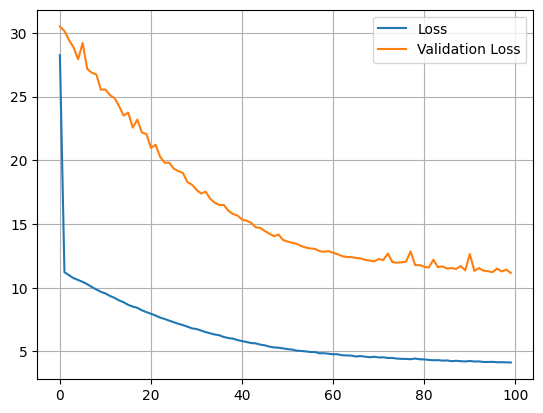

In [123]:
plt.plot(epoch_life, loss, label="Loss")
plt.plot(epoch_life, val_loss, label="Validation Loss")
plt.legend(loc=1)
plt.grid(True)
plt.show()

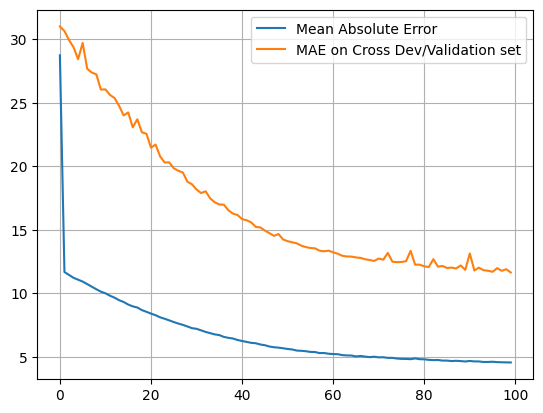

In [124]:
plt.plot(epoch_life, mae, label="Mean Absolute Error")
plt.plot(epoch_life, val_mae, label="MAE on Cross Dev/Validation set")
plt.grid(True)
plt.legend(loc=1)
plt.show()

In [125]:
# Checking layer weights:
print(l0.get_weights())

[array([[ 0.17445491],
       [-0.21382535],
       [ 0.20617452],
       [-0.09382523],
       [-0.01025025],
       [-0.02154189],
       [ 0.08446457],
       [ 0.09943028],
       [ 0.03050534],
       [ 0.7380094 ]], dtype=float32), array([-0.00560039], dtype=float32)]


In [126]:
series = np.array(series)

In [127]:
# Checking out by forecasting for 1 window
start = split_time - window_size
output = model.predict(series[start:split_time][np.newaxis])
print("Actual Price: ${}".format(series[split_time]))
print("Predicted Price: ${}".format(output.squeeze()))

1/1 [==============================] - 0s 46ms/step
Actual Price: $148.38
Predicted Price: $160.8489990234375


### Chores: 
To perform sanity check, normalize data, and optionally set a benchmark for the model using statistical methods